In [1]:
!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

!pip install tqdm
from tqdm import tqdm

from random import sample

In [81]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_stand2.parquet")
df_cct

,User,Card,Month,Day,Hours,year_diff,Amount,Use Chip,Card Brand,Card Type,...,nb_daily_declines_card,nb_monthly_declines_card,bad_pin,insufficient_balance,hr_nbt/last_30d_av_hr_nbt,day_nbt/last_30d_av_day_nbt,last_3d_amt/nbt,label_global,Is Fraud?,pos_amount
0,0,0,0.333333,-1.000000,0.000000,-1.0,0.693441,Swipe Transaction,Visa,Debit,...,0.0,-0.5,0,0,0.430959,0.131732,1.006352,0,0,1
1,0,0,0.333333,-1.000000,0.000000,-1.0,-0.394334,Swipe Transaction,Visa,Debit,...,0.0,-0.5,0,0,0.430959,0.131732,0.011261,0,0,1
2,0,0,0.333333,-0.933333,0.000000,-1.0,0.537004,Swipe Transaction,Visa,Debit,...,0.0,-0.5,0,0,-0.430959,0.131732,0.247553,0,0,1
3,0,0,0.333333,-0.933333,1.571429,-1.0,0.634962,Swipe Transaction,Visa,Debit,...,0.0,-0.5,0,0,-0.287306,0.131732,0.410505,0,0,1
4,0,0,0.333333,-0.866667,0.000000,-1.0,0.359179,Swipe Transaction,Visa,Debit,...,0.0,-0.5,0,0,-0.184697,0.131732,0.407362,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,-0.833333,0.800000,0.916667,1.0,0.059421,Chip Transaction,Visa,Credit,...,0.0,0.0,0,0,2.665306,1.144988,0.221986,0,0,0
24386896,1999,1,-0.833333,0.800000,0.916667,1.0,0.059421,Chip Transaction,Visa,Credit,...,0.0,0.0,0,0,2.622500,1.131036,0.198821,0,0,1
24386897,1999,1,-0.833333,0.866667,-0.333333,1.0,0.260751,Chip Transaction,Visa,Credit,...,0.0,0.0,0,0,0.099149,-0.722775,-0.256704,0,0,1
24386898,1999,1,-0.833333,0.866667,0.750000,1.0,-0.365911,Chip Transaction,Visa,Credit,...,0.0,0.0,0,0,0.096847,-0.730202,-0.288962,0,0,1


In [82]:
# resorting dataframe according to time
# IGNORE
df = pd.read_parquet("/home/onyxia/work/cct.parquet")
df_amount = pd.read_parquet("/home/onyxia/work/df_all.parquet")
df.sort_values(["Year","Month","Day","Time"], inplace=True)
df_cct["abs_amount"] = list(df_amount.loc[df_cct.index]["Amount"].abs().values)
df_cct  = df_cct.loc[df.index]


In [109]:
df_test_final = pd.read_parquet("/home/onyxia/work/df_test_final.parquet")

In [98]:
df_2019 = df[df["Year"] == 2019]
df_test_final = pd.concat([df_2019[df_2019["Is Fraud?"] == "Yes"], df_2019[df_2019["Is Fraud?"] == "No"].sample(38000, random_state = 0)], axis = 0)
df_test_final

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
22328371,1681,3,2019,1,1,11:10,$78.00,Chip Transaction,1799189980464955940,Rome,Italy,NaN,5499,None,Yes
22328616,840,3,2019,1,1,11:47,$15.11,Chip Transaction,5507353000713503121,Rome,Italy,NaN,4121,None,Yes
22328637,840,3,2019,1,1,11:50,$79.35,Chip Transaction,-6161792371494728879,Rome,Italy,NaN,3389,None,Yes
22328802,1473,1,2019,1,1,12:15,$1.19,Chip Transaction,6341249420865687678,Rome,Italy,NaN,7210,None,Yes
22328909,1681,3,2019,1,1,12:32,$107.00,Chip Transaction,190253443608377572,Rome,Italy,NaN,3359,None,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23001232,65,1,2019,5,24,06:22,$104.43,Chip Transaction,-6738340320657348028,Rock Hall,MD,21661.0,7538,None,No
23932490,1976,2,2019,12,7,07:21,$17.15,Chip Transaction,852314270731746635,Dover,AR,72837.0,5411,None,No
23311305,1281,0,2019,7,28,10:50,$165.67,Chip Transaction,-5407820841492077733,Jamul,CA,91935.0,7996,None,No
22691394,1432,0,2019,3,19,08:15,$64.00,Chip Transaction,1799189980464955940,Newark,DE,19713.0,5499,None,No


In [110]:
df_cct = pd.read_parquet("/home/onyxia/work/df_manual_sampling.parquet")

In [111]:
# we drop 2020 because no frauds, and we want to make our final test on most recent transactions
df_cct = df_cct.loc[:24050400]

In [78]:
# df_cct.to_parquet("/home/onyxia/work/df_manual_sampling.parquet")

## Copy from here

In [112]:
# For "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [113]:
# For "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [114]:
# For "Card Type":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [115]:
# For "label global":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["label_global"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [116]:
df_cct.rename(columns={0:"0", -1: "-1", 1:"1", 2:"2", 3: "3", 4:"4", 5:"5", 6:"6"}, inplace=True)


In [118]:
X_test_ = df_test_final[['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
              'Credit Limit', 'delta_t_s',
              'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
              'nb_monthly_declines_card', 'bad_pin',
              'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
              'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
              'Swipe Transaction','Debit (Prepaid)',"-1","0","1","2","3","4","5","6"]]

y_test_ = df_test_final["Is Fraud?"]

In [117]:
# selecting features

features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"Is Fraud?",
        "-1","0","1","2","3","4","5","6"]

df_selec = df_cct[features] # 21 features + clusters

### Manual Split

In [119]:
df_select = df_selec.loc[:22326461] # we stop at 2018

In [120]:
df_split = np.array_split(df_select, 10)

In [121]:
# undersampling non frauds to have 5% frauds
for i in range(10):
    df_fraud = df_split[i][df_split[i]["Is Fraud?"] == 1]
    n_fraud = len(df_split[i][df_split[i]["Is Fraud?"] == 1])
    df_no_fraud = df_split[i][df_split[i]["Is Fraud?"] == 0]
    df_no_fraud_sampled = df_no_fraud.sample(int(0.95*(n_fraud/0.05)), random_state = 0)
    df_split[i] = pd.concat([df_no_fraud_sampled, df_fraud], axis = 0).sort_index()

In [122]:
for i in range(10):
    print(len(df_split[i]))

33860
40540
115160
81440
18800
29880
41600
98720
38480
54920


In [124]:
# defining X,y in each subdataset
X = {}
y = {}
for i in range(10):
       X_train[i] = df_split[i][['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
              'Credit Limit', 'delta_t_s',
              'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
              'nb_monthly_declines_card', 'bad_pin',
              'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
              'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
              'Swipe Transaction','Debit (Prepaid)',"-1","0","1","2","3","4","5","6"]]
              
       y_train[i] = df_split[i]["Is Fraud?"]

In [46]:
## Splitting the data into train and test data  (70:30) in each subdataset

## Create a STRATIFIED train-test (Hence, passing the argument 'stratify= y')
X_train = {}
y_train = {}
X_test = {}
y_test = {}
for i in range(10): 
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], train_size=0.7, shuffle = True, random_state = 0)

In [125]:
#building our own score
def our_score(df_cct, clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = df_cct.loc[fp_rows]
    fp_new = df_fp.loc[df_fp["abs_amount"]>=15].index

    df_tp = df_cct.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["abs_amount"]>=15].index

    df_fn = df_cct.loc[fn_rows]
    fn_new = df_fn.loc[df_fn["abs_amount"]>=15].index

    our_score = -15*(len(fp_new) + len(tp_new)) + df_cct.loc[tp_new]["abs_amount"].sum() - df_cct.loc[fn_rows]["abs_amount"].sum() - df_cct.loc[tp_rows]["abs_amount"].sum()

    our_score_norm = (our_score + df_cct.loc[fn_rows]["abs_amount"].sum() + df_cct.loc[tp_rows]["abs_amount"].sum())/(df_cct.loc[tp_new]["abs_amount"].sum()+df_cct.loc[fn_new]["abs_amount"].sum() - 15*(len(tp_new)+len(fn_new)))

    return our_score_norm

In [126]:
#calculate retrieved or lost money
def retrieved_money(df_cct, clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = df_cct.loc[fp_rows]
    fp_new = df_fp.loc[df_fp["abs_amount"]>=15].index

    df_tp = df_cct.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["abs_amount"]>=15].index

    df_fn = df_cct.loc[fn_rows]
    fn_new = df_fn.loc[df_fn["abs_amount"]>=15].index

    initial_loss = - df_cct.loc[fn_rows]["abs_amount"].sum() - df_cct.loc[tp_rows]["abs_amount"].sum()

    retrieved_money = -15*(len(fp_new) + len(tp_new)) + df_cct.loc[tp_new]["abs_amount"].sum() 

    max_retrieved_money = df_cct.loc[tp_new]["abs_amount"].sum()+df_cct.loc[fn_new]["abs_amount"].sum() - 15*(len(tp_new)+len(fn_new))

    return initial_loss, retrieved_money, max_retrieved_money

In [127]:
# plot confusion matrix
def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Non-Fraudulent','Fraudulent']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)

In [50]:
results_df = pd.DataFrame(columns = ["param", "our_score_cv","min_our_score_cv", 
"max_our_score_cv", "f1_cv", "precision_cv", "recall_cv", "initial_loss_mean", "retrieved_money_mean", "retrievable_money_mean"])

In [51]:
# Manual gridsearch
import itertools
from statistics import mean

# manual gridsearch with parameters we want to tune
grid_search_dicts =  [dict(zip(['class_weight', "n_estimators",'max_depth', 'min_samples_leaf'], [a, b, c, d]))
for a, b, c, d in itertools.product([{1:i, 0:1} for i in [10, 15, 20]], [50, 100, 200, 300], [1, 5, 10, 15, 20], [1, 5, 10, 25, 50, 100, 200])]


for i in tqdm(range(len(grid_search_dicts))): # for each set of parameters
    my_score = [] # creating lists for all the scores
    f1 = []
    recall = []
    precision = []
    initial_loss = []
    retriev_money = []
    retrievable_money = []
    for j in tqdm(range(10)): # for each subdataset
        model = RandomForestClassifier(**grid_search_dicts[i]) 
        model.fit(X_train[j], y_train[j]) # fit the model
        y_pred = model.predict(X_test[j]) # predict on test set
        my_score.append(our_score(model, X_test[j], y_test[j])) # add the following metric scores to the list
        f1.append(f1_score(y_test[j], y_pred))
        recall.append(recall_score(y_test[j], y_pred))
        precision.append(precision_score(y_test[j], y_pred))
        initial_loss.append(retrieved_money(model, X_test[j], y_test[j])[0])
        retriev_money.append(retrieved_money(model, X_test[j], y_test[j])[1])
        retrievable_money.append(retrieved_money(model, X_test[j], y_test[j])[2])
    results_df.loc[len(results_df)] = [grid_search_dicts[i], mean(my_score), 
    min(my_score), max(my_score), mean(f1), mean(precision), mean(recall),
    mean(initial_loss), mean(retriev_money), mean(retrievable_money)] # add results to dataframe

        

  0%|          | 0/420 [00:00<?, ?it/s]/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/420 [00:22<1:16:55, 11.04s/it]/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/420 [00:33<1:16:55, 11.07s/it]/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

In [128]:
# saving the results into csv
results_df.to_csv("/home/onyxia/work/manual_cv_rf.csv")

In [52]:
#printing best parameters according to our score
results_df.loc[results_df["our_score_cv"].idxmax()]["param"]

{'class_weight': {1: 20, 0: 1},
 'n_estimators': 300,
 'max_depth': 20,
 'min_samples_leaf': 10}

In [53]:
results_df.loc[results_df["our_score_cv"].idxmax()]

param                     {'class_weight': {1: 20, 0: 1}, 'n_estimators'...
our_score_cv                                                       0.757139
min_our_score_cv                                                   0.536252
max_our_score_cv                                                   0.887626
f1_cv                                                              0.602474
precision_cv                                                       0.531427
recall_cv                                                          0.697463
initial_loss_mean                                                -109949.86
retrieved_money_mean                                              77607.454
retrievable_money_mean                                            98806.761
Name: 415, dtype: object

In [157]:
results_df.loc[results_df["our_score_cv"].idxmax()]

param                     {'class_weight': {1: 20, 0: 1}, 'n_estimators'...
our_score_cv                                                       0.715663
min_our_score_cv                                                   0.474112
max_our_score_cv                                                   0.899351
f1_cv                                                              0.585013
precision_cv                                                        0.52064
recall_cv                                                          0.672574
initial_loss_mean                                               -109490.016
retrieved_money_mean                                              75741.078
retrievable_money_mean                                            97825.904
Name: 520, dtype: object

In [54]:
results_df.sort_values("our_score_cv", ascending=False).head(10)

,param,our_score_cv,min_our_score_cv,max_our_score_cv,f1_cv,precision_cv,recall_cv,initial_loss_mean,retrieved_money_mean,retrievable_money_mean
415,"{'class_weight': {1: 20, 0: 1}, 'n_estimators'...",0.757139,0.536252,0.887626,0.602474,0.531427,0.697463,-109949.86,77607.454,98806.761
275,"{'class_weight': {1: 15, 0: 1}, 'n_estimators'...",0.757127,0.544651,0.890734,0.611635,0.557119,0.682851,-109949.86,77555.401,98806.761
310,"{'class_weight': {1: 20, 0: 1}, 'n_estimators'...",0.756312,0.543161,0.887622,0.599794,0.526505,0.698518,-109949.86,77433.002,98806.761
380,"{'class_weight': {1: 20, 0: 1}, 'n_estimators'...",0.756198,0.549083,0.887163,0.601611,0.531552,0.695098,-109949.86,77501.674,98806.761
338,"{'class_weight': {1: 20, 0: 1}, 'n_estimators'...",0.756076,0.511815,0.887102,0.598256,0.517512,0.712083,-109949.86,77567.668,98806.761
101,"{'class_weight': {1: 10, 0: 1}, 'n_estimators'...",0.756044,0.546966,0.884241,0.579217,0.492916,0.703467,-109949.86,77434.692,98806.761
345,"{'class_weight': {1: 20, 0: 1}, 'n_estimators'...",0.755997,0.550291,0.885843,0.600412,0.528720,0.696602,-109949.86,77513.020,98806.761
198,"{'class_weight': {1: 15, 0: 1}, 'n_estimators'...",0.754099,0.516723,0.887968,0.605900,0.540013,0.692035,-109949.86,77410.952,98806.761
408,"{'class_weight': {1: 20, 0: 1}, 'n_estimators'...",0.753930,0.492175,0.888921,0.598009,0.518868,0.708923,-109949.86,77414.745,98806.761
303,"{'class_weight': {1: 20, 0: 1}, 'n_estimators'...",0.753667,0.512487,0.890447,0.593363,0.509965,0.712292,-109949.86,77451.793,98806.761


### Results on test set

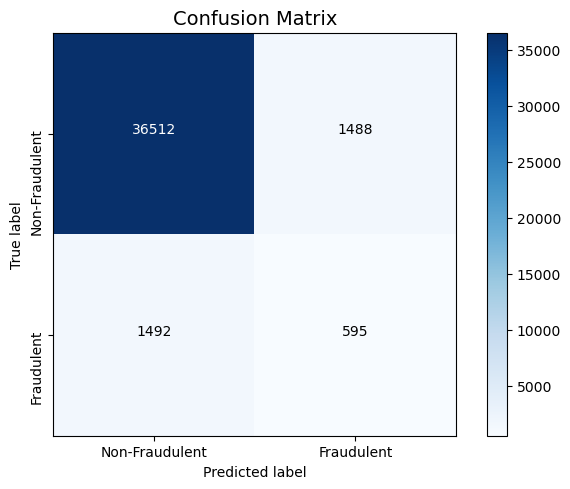

In [134]:
rf = RandomForestClassifier(random_state = 0, class_weight = {1: 20, 0: 1}, n_estimators= 300, max_depth= 20, min_samples_leaf= 10, n_jobs = -1)
rf.fit(X_train[9], y_train[9])
y_pred = rf.predict(X_test_)
cm = confusion_matrix(y_test_, y_pred)
plot_confusion_matrix(cm)

In [136]:
our_score(df_test_final, rf, X_test_,y_test_)

0.4772107153742163

In [137]:
f1_score(y_test_, y_pred)

0.2853717026378897

In [ ]:
f1_score(y_test_, y_pred)

0.2853717026378897